In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
import scipy.stats
import time

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

np.random.seed(1942)

# 1. Linear Regression on Generic Data

## 1.1 The Franke Funtion, with noise

In [2]:
def Franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeNoise(x, y, sigma=1):
    return Franke(x, y) + np.random.normal(0, sigma, np.shape(x))

In [49]:
nr_points_per_dim = 201
nr_datapoints = nr_points_per_dim**2

### 1.1.1 Plotting the Franke Function, with and without noise

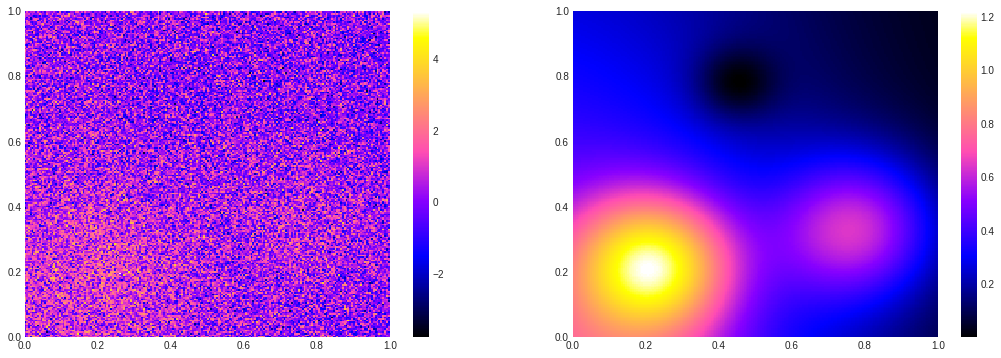

In [50]:
x = np.linspace(0, 1, nr_points_per_dim)
y = np.linspace(0, 1, nr_points_per_dim)
#x = np.random.uniform(0, 1, nr_points_per_dim)
#y = np.random.uniform(0, 1, nr_points_per_dim)
x_, y_ = np.meshgrid(x, y)

x_flat = x_.flatten()
y_flat = y_.flatten()

data = FrankeNoise(x_, y_)
f = data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
plt1 = ax1.pcolormesh(x_, y_, FrankeNoise(x_,y_));
fig.colorbar(plt1, ax=ax1);

plt2 = ax2.pcolormesh(x_, y_, Franke(x_, y_))
fig.colorbar(plt2, ax=ax2);

## 1.2 Setting up the design matrix and model

In [51]:
poly_order = 5

### 1.2.1 The design matrix, X

In [81]:
def make_X(x_flat, y_flat, poly_order):
    nr_terms = ((poly_order + 1)*(poly_order + 2))//2
    X = np.zeros((np.size(x_flat), nr_terms))
    X[:,0] = 1

    i = 0
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                X[:,i] = x_flat**ix*y_flat**iy
    return X

### 1.2.2 The Model

In [53]:
def Model(beta, x, y, poly_order):
    i = 0
    result = beta[0]
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                result += beta[i]*x**ix*y**iy
    return result

## 1.3 Predicting model from noisy data with Linear Regression using OLS

In [54]:
X = make_X(x_flat, y_flat, poly_order)
beta = np.linalg.inv(X.T@X)@X.T@f
data_pred = Model(beta, x_, y_, poly_order)

## 1.4 Results

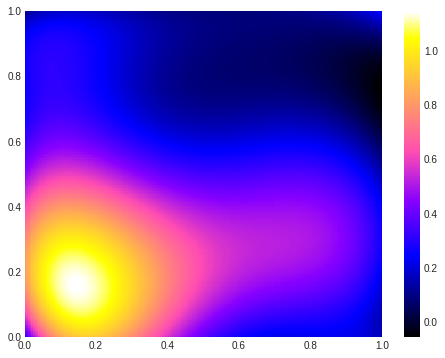

In [55]:
plt.figure(figsize=(8,6))
plt.pcolormesh(x_, y_, data_pred)
plt.colorbar();

## 1.4.1 Score values

In [56]:
print("MSE Score = ", MSE(data, data_pred))
print("RRMSE Score = ", np.sqrt(MSE(data, data_pred))/np.mean(data))
print("MSE Score (vs true model) =", MSE(Franke(x_, y_), data_pred))

MSE Score =  0.9977621141332749
RRMSE Score =  2.5208832700227277
MSE Score (vs true model) = 0.002800612575863784


In [57]:
print("R2 Score = ", r2_score(data, data_pred))

R2 Score =  0.04835737591524037


## 1.4.2 Analysing the noise

In [58]:
noise_pred = data - data_pred

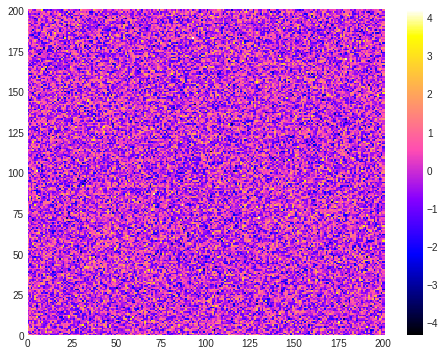

In [59]:
plt.figure(figsize = (8, 6))
plt.pcolormesh(noise_pred)
plt.colorbar();

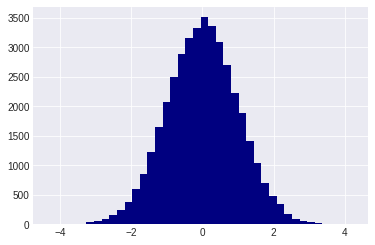

In [60]:
plt.hist(noise_pred.flatten(), bins=40, color="navy");

### 1.4.3 Probability Plot - Confirming normal distribution of noise

0.9999806973874025

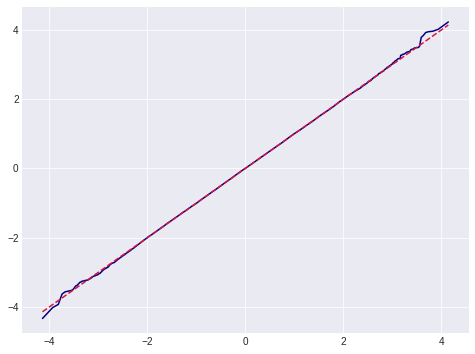

In [61]:
(x, y), (slope, intercept, r) = scipy.stats.probplot(noise_pred.flatten());

plt.figure(figsize = (8,6))
plt.plot(x, y, color="navy");
plt.plot(x, intercept + x*slope, ls="--", c="crimson")
r

## 1.5 Round 2 - Running the model for different polynomial degrees

0.0014004707336425781
0.003675222396850586
0.012585639953613281
0.029453277587890625
0.05230426788330078
0.08729934692382812
0.11237096786499023
0.1483912467956543
0.1700301170349121
0.20951128005981445
0.23525047302246094
0.282254695892334
0.3109257221221924
0.36324167251586914
0.45522427558898926
0.5518484115600586


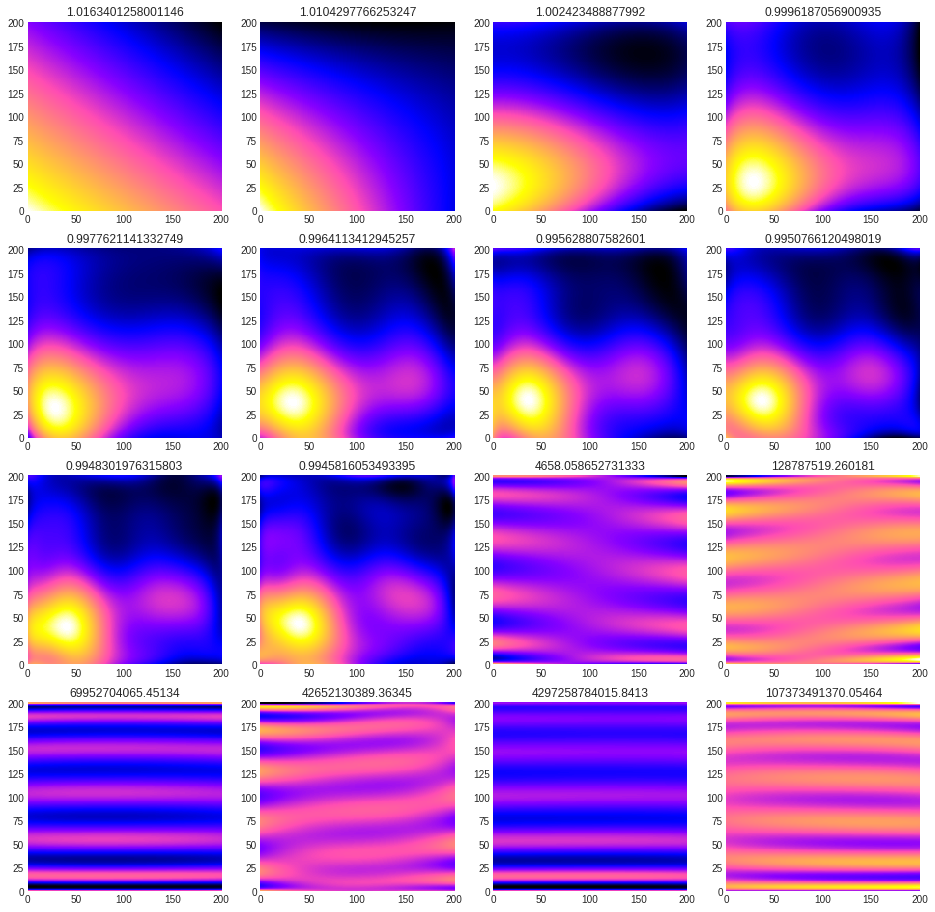

In [62]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 16
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

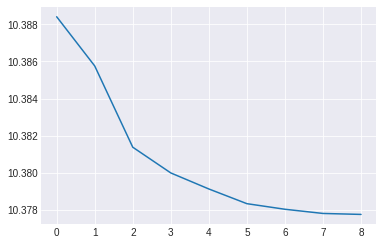

In [63]:
plt.plot(np.log(err_list[:9]));

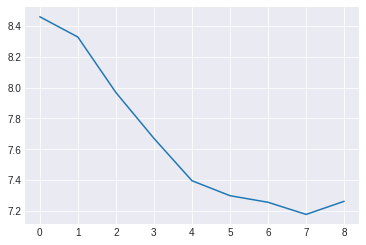

In [64]:
plt.plot(np.log(err_list_truemodel[:9]));

# 2 Ridge Regression

0.0037131309509277344
0.003702402114868164
0.012594223022460938
0.029382705688476562
0.05262589454650879
0.0811011791229248
0.11322140693664551
0.13779902458190918
0.17534494400024414
0.20920276641845703
0.22960138320922852
0.2643091678619385
0.31396484375
0.3754580020904541
0.427715539932251
0.48133182525634766
0.5390734672546387
0.5979483127593994
0.7204074859619141
0.8760056495666504
0.9412918090820312
0.9517552852630615
1.0324592590332031
1.0817911624908447
1.1675963401794434
1.3115589618682861
1.538400650024414
1.6868784427642822
1.7506325244903564
1.9385545253753662
1.9767873287200928
2.0536916255950928
2.182108163833618
2.3132078647613525
2.520705461502075
2.6743898391723633
2.8512964248657227
3.0441465377807617
3.4928364753723145
3.7320950031280518


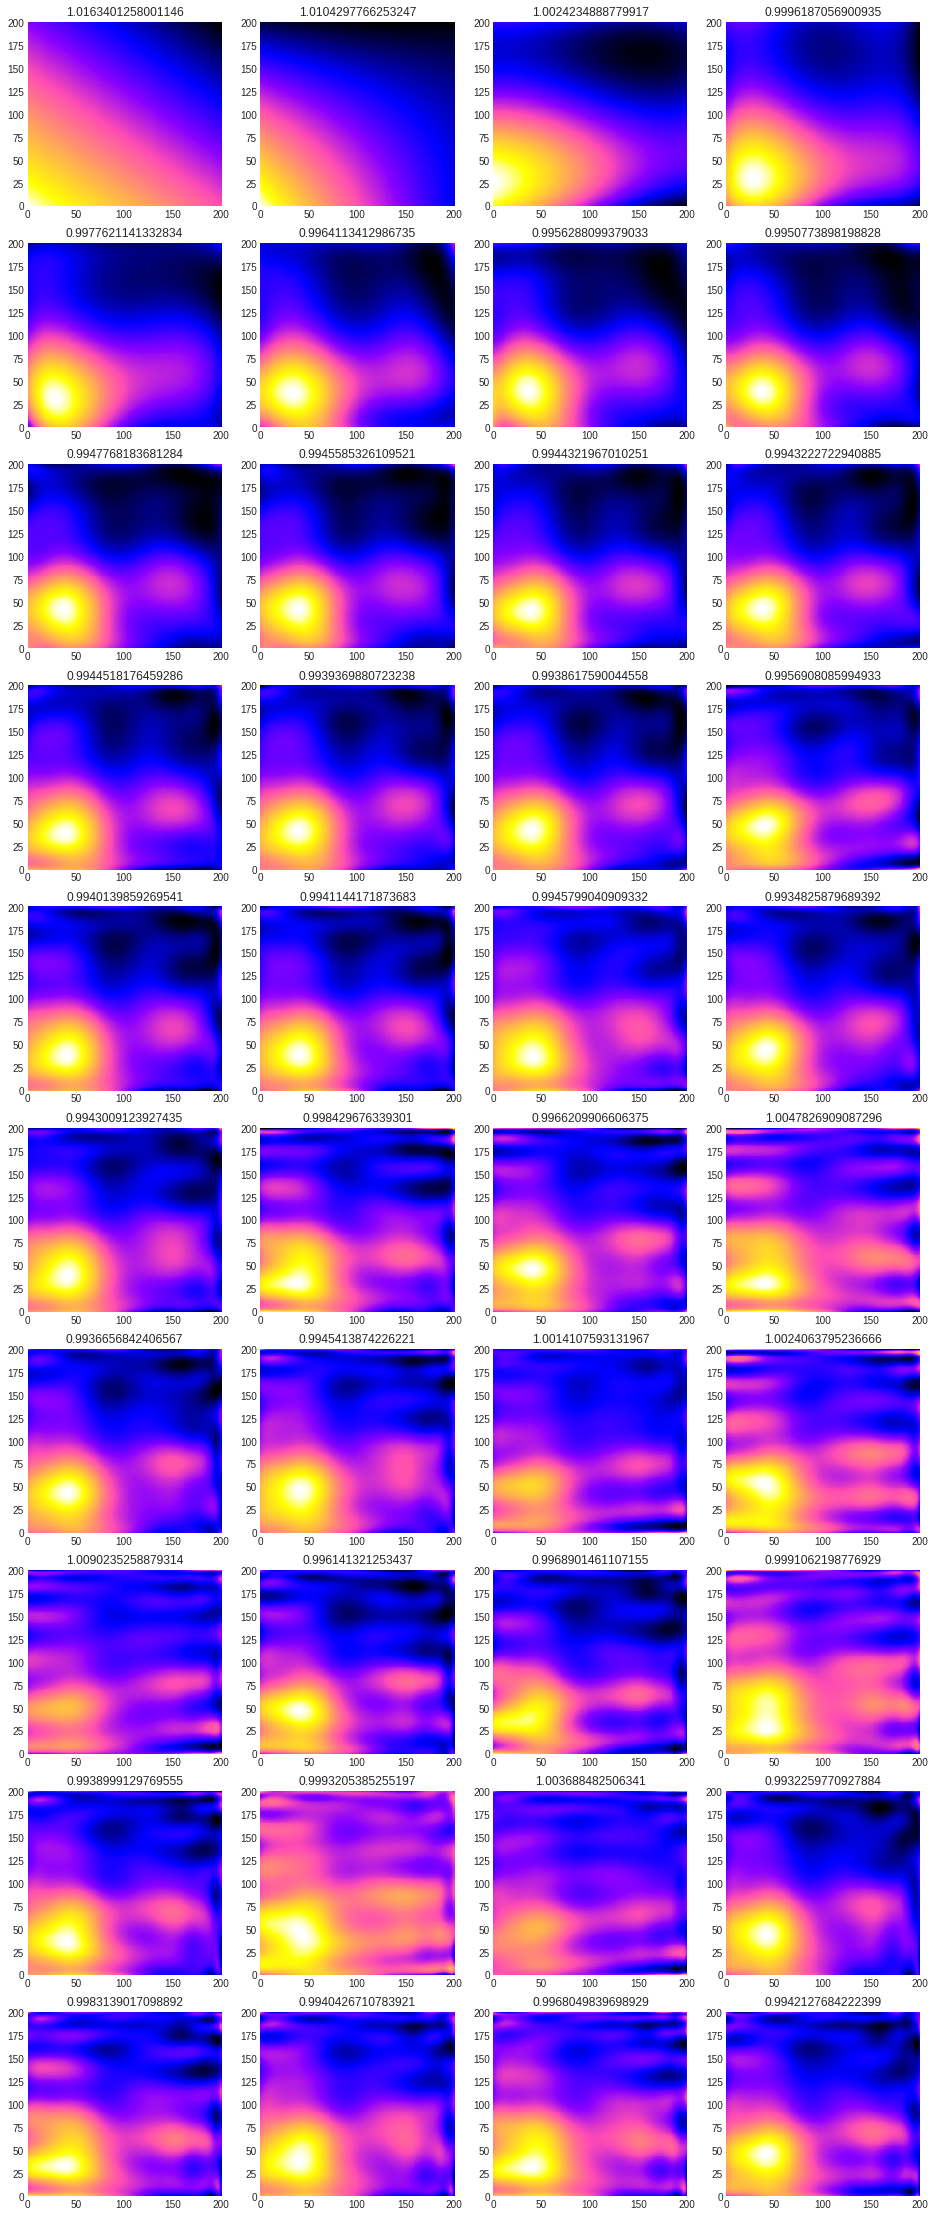

In [65]:
lamda = 1e-8

err_list = []
err_list_truemodel = []
nr_poly_orders = 40
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X + np.identity(X.shape[1])*lamda)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

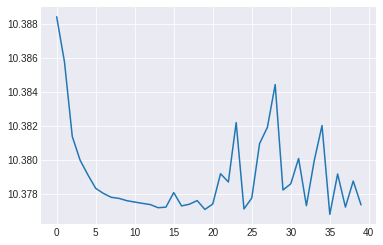

In [66]:
plt.plot(np.log(err_list));

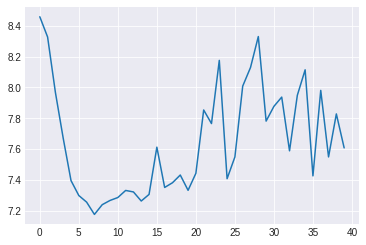

In [67]:
plt.plot(np.log(err_list_truemodel));

# 3. Train-test split

In [104]:
poly_order = 5

input_ = np.zeros((nr_datapoints, 2))
input_[:,0] = x_flat
input_[:,1] = y_flat

In [105]:
input_train, input_test, output_train, output_test = train_test_split(input_, f, test_size = 0.3)

In [106]:
X = make_X(input_train[:,0], input_train[:,1], poly_order)
beta = np.linalg.inv(X.T@X)@X.T@output_train

output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)

In [107]:
MSE(output_test, output_test_pred)

0.9896835682167948

# 4. K-fold validation

In [144]:
#class KFold_iterator
#    def __init__(self, input_dim, nr_splits=5):
    

#def KFold_indexes(input_dim, nr_splits=5):
#    indexes = np.arange(input_dim)
#    np.random.shuffle(indexes)
#    cut_indexes = np.array_split(indexes, nr_splits)
#    print(cut_indexes)
#KFold_indexes(10)

[array([4, 2]), array([8, 3]), array([0, 5]), array([9, 6]), array([7, 1])]


In [126]:
def K_fold_validation(input_, output, K=5):
    output_pred = np.zeros(nr_datapoints)
    kf = KFold(n_splits = K, shuffle=True)
    for train_index, test_index in kf.split(input_):
        input_train, input_test = input_[train_index], input_[test_index]
        output_train, output_test = output[train_index], output[test_index]
        X = make_X(input_train[:,0], input_train[:,1], poly_order)
        beta = np.linalg.inv(X.T@X)@X.T@output_train

        output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)
        output_pred[test_index] = output_test_pred
    return output_pred

In [127]:
output_pred = K_fold_validation(input_, f)

In [128]:
MSE(output_pred, f)

0.9990200499108907